In [18]:
import csv
import os
#to install fitparse, run 
#sudo pip3 install -e git+https://github.com/dtcooper/python-fitparse#egg=python-fitparse
import fitparse
import pytz
from datetime import datetime
import datetime as DT
allowed_fields = ['timestamp','heart_rate','timestamp_16']
required_fields = ['heart_rate']

UTC = pytz.UTC


def main():
    files = os.listdir(os.getcwd()+'/data')
    fit_files = [file for file in files if file[-4:].lower()=='.fit']
    for file in fit_files:
        new_filename = os.getcwd()+'/data/'+file[:-4] + '.csv'
        if os.path.exists(new_filename):
            print('%s already exists. skipping.' % new_filename)
            continue
        fitfile = fitparse.FitFile(os.getcwd()+'/data/'+file,  
            data_processor=fitparse.StandardUnitsDataProcessor())
        
        print('converting %s' % file)
        write_fitfile_to_csv(fitfile, new_filename)
    print('finished conversions')

epoch = datetime.utcfromtimestamp(0)
def unix_time_s(dt):
    return (dt - epoch).total_seconds()

def write_fitfile_to_csv(fitfile, output_file='test_output.csv'):
    messages = fitfile.messages
    data = []
    timestamp_16_found = False
    initial_timestamp = None
    initial_timestamp_16 = None
    last_timestamp = None
    counter = 0
    for i,m in enumerate(messages):
        
        skip=False
        if not hasattr(m, 'fields'):
            continue
        fields = m.fields
        #check for important data types
        mdata = {}
        print(i, fields)
        print('--')
        for field in fields:
            
            if field.name in allowed_fields:
                if field.name=='timestamp' and timestamp_16_found is False :
                    initial_timestamp = unix_time_s(field.value)
                    mdata['timestamp'] = field.value # fill in the value with the timestamp. 
                if field.name=='timestamp_16':
                    if timestamp_16_found is False:
                        timestamp_16_found = True
                        initial_timestamp_16 = field.value
                    else:
                        # this is in seconds since epoch
                        mdata['timestamp_s'] = initial_timestamp + (field.value - initial_timestamp_16)
                        mdata['timestamp'] = datetime.utcfromtimestamp(mdata['timestamp_s']).strftime('%Y-%m-%d %H:%M:%S')
                        
                mdata[field.name] = field.value
            
        
        for rf in required_fields:
            if rf not in mdata:
                skip=True
                
#         print(mdata)
#         print('--')
        
#         try:
#             #print(last_timestamp, mdata['timestamp_s'])
            
#             if last_timestamp is None:
#                 last_timestamp = mdata['timestamp_s']
#             #print(i,last_timestamp > mdata['timestamp_s'])
#             if last_timestamp > mdata['timestamp_s']:
#                 skip = True
#         except:
#             continue
        
        if not skip:
            counter += 1
            
            data.append(mdata)

    
    #write to csv
    with open(output_file, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(allowed_fields)
        for entry in data:
            writer.writerow([ str(entry.get(k, '')) for k in allowed_fields])
    print('wrote %s' % output_file)

main()

converting 2020-05-16-10-04-03 (1).fit
0 [<FieldData: serial_number: 3315759468, def num: 3, type: uint32z (uint32z), raw value: 3315759468>, <FieldData: time_created: 2020-05-16 00:04:03, def num: 4, type: date_time (uint32), raw value: 958521843>, <FieldData: unknown_7: None, def num: 7, type: uint32 (uint32), raw value: None>, <FieldData: manufacturer: garmin, def num: 1, type: manufacturer (uint16), raw value: 1>, <FieldData: garmin_product: 3282, def num: 2, type: garmin_product (uint16), raw value: 3282>, <FieldData: number: None, def num: 5, type: uint16 (uint16), raw value: None>, <FieldData: type: activity, def num: 0, type: file (enum), raw value: 4>]
--
1 [<FieldData: unknown_2: None, def num: 2, type: string (string), raw value: None>, <FieldData: software_version: 360, def num: 0, type: uint16 (uint16), raw value: 360>, <FieldData: hardware_version: None, def num: 1, type: uint8 (uint8), raw value: None>]
--
2 [<FieldData: unknown_253: 958521843, def num: 253, type: uint32

--
687 [<FieldData: unknown_2: (2, 184, 2, 40), def num: 2, type: byte (byte), raw value: (2, 184, 2, 40)>]
--
688 [<FieldData: timestamp: 2020-05-16 00:12:49, def num: 253, type: date_time (uint32), raw value: 958522369>, <FieldData: position_lat: -33.89150094240904 [deg], def num: 0, type: sint32 (sint32), raw value: -404341356>, <FieldData: position_long: 151.23449033126235 [deg], def num: 1, type: sint32 (sint32), raw value: 1804297750>, <FieldData: distance: 1.8277 [km], def num: 5, type: uint32 (uint32), raw value: 182770>, <FieldData: enhanced_altitude: 64.39999999999998 [m], def num: 78, type: uint32 (uint32), raw value: 64.39999999999998>, <FieldData: altitude: 64.39999999999998 [m], def num: 2, type: uint16 (uint16), raw value: 2822>, <FieldData: enhanced_speed: 12.6972 [km/h], def num: 73, type: uint32 (uint32), raw value: 3.527>, <FieldData: speed: 12.6972 [km/h], def num: 6, type: uint16 (uint16), raw value: 3527>, <FieldData: unknown_88: 300, def num: 88, type: uint16 (ui

1474 [<FieldData: unknown_2: (4, 0, 0, 72), def num: 2, type: byte (byte), raw value: (4, 0, 0, 72)>]
--
1475 [<FieldData: unknown_2: (27, 85, 2, 0), def num: 2, type: byte (byte), raw value: (27, 85, 2, 0)>]
--
1476 [<FieldData: unknown_2: (36, 240, 79, 8), def num: 2, type: byte (byte), raw value: (36, 240, 79, 8)>]
--
1477 [<FieldData: unknown_2: (20, 0, 0, 16), def num: 2, type: byte (byte), raw value: (20, 0, 0, 16)>]
--
1478 [<FieldData: timestamp: 2020-05-16 00:23:27, def num: 253, type: date_time (uint32), raw value: 958523007>, <FieldData: position_lat: -33.8993757404387 [deg], def num: 0, type: sint32 (sint32), raw value: -404435306>, <FieldData: position_long: 151.24196120537817 [deg], def num: 1, type: sint32 (sint32), raw value: 1804386881>, <FieldData: distance: 3.63031 [km], def num: 5, type: uint32 (uint32), raw value: 363031>, <FieldData: enhanced_altitude: 53.799999999999955 [m], def num: 78, type: uint32 (uint32), raw value: 53.799999999999955>, <FieldData: altitude:

2144 [<FieldData: unknown_2: (2, 192, 2, 40), def num: 2, type: byte (byte), raw value: (2, 192, 2, 40)>]
--
2145 [<FieldData: unknown_2: (206, 21, 11, 48), def num: 2, type: byte (byte), raw value: (206, 21, 11, 48)>]
--
2146 [<FieldData: unknown_2: (98, 201, 36, 56), def num: 2, type: byte (byte), raw value: (98, 201, 36, 56)>]
--
2147 [<FieldData: unknown_2: (40, 100, 162, 64), def num: 2, type: byte (byte), raw value: (40, 100, 162, 64)>]
--
2148 [<FieldData: timestamp: 2020-05-16 00:32:32, def num: 253, type: date_time (uint32), raw value: 958523552>, <FieldData: position_lat: -33.90481559559703 [deg], def num: 0, type: sint32 (sint32), raw value: -404500206>, <FieldData: position_long: 151.232420084998 [deg], def num: 1, type: sint32 (sint32), raw value: 1804273051>, <FieldData: distance: 5.429279999999999 [km], def num: 5, type: uint32 (uint32), raw value: 542928>, <FieldData: enhanced_altitude: 38.39999999999998 [m], def num: 78, type: uint32 (uint32), raw value: 38.39999999999

0 [<FieldData: serial_number: 3315759468, def num: 3, type: uint32z (uint32z), raw value: 3315759468>, <FieldData: time_created: 2020-05-16 00:04:03, def num: 4, type: date_time (uint32), raw value: 958521843>, <FieldData: unknown_7: None, def num: 7, type: uint32 (uint32), raw value: None>, <FieldData: manufacturer: garmin, def num: 1, type: manufacturer (uint16), raw value: 1>, <FieldData: garmin_product: 3282, def num: 2, type: garmin_product (uint16), raw value: 3282>, <FieldData: number: None, def num: 5, type: uint16 (uint16), raw value: None>, <FieldData: type: activity, def num: 0, type: file (enum), raw value: 4>]
--
1 [<FieldData: unknown_2: None, def num: 2, type: string (string), raw value: None>, <FieldData: software_version: 360, def num: 0, type: uint16 (uint16), raw value: 360>, <FieldData: hardware_version: None, def num: 1, type: uint8 (uint8), raw value: None>]
--
2 [<FieldData: unknown_253: 958521843, def num: 253, type: uint32 (uint32), raw value: 958521843>, <Fiel

723 [<FieldData: timestamp: 2020-05-16 00:13:16, def num: 253, type: date_time (uint32), raw value: 958522396>, <FieldData: position_lat: -33.891784669831395 [deg], def num: 0, type: sint32 (sint32), raw value: -404344741>, <FieldData: position_long: 151.2353436090052 [deg], def num: 1, type: sint32 (sint32), raw value: 1804307930>, <FieldData: distance: 1.9173399999999998 [km], def num: 5, type: uint32 (uint32), raw value: 191734>, <FieldData: enhanced_altitude: 71.0 [m], def num: 78, type: uint32 (uint32), raw value: 71.0>, <FieldData: altitude: 71.0 [m], def num: 2, type: uint16 (uint16), raw value: 2855>, <FieldData: enhanced_speed: 12.8664 [km/h], def num: 73, type: uint32 (uint32), raw value: 3.574>, <FieldData: speed: 12.8664 [km/h], def num: 6, type: uint16 (uint16), raw value: 3574>, <FieldData: unknown_88: 300, def num: 88, type: uint16 (uint16), raw value: 300>, <FieldData: heart_rate: 176 [bpm], def num: 3, type: uint8 (uint8), raw value: 176>, <FieldData: cadence: 74 [rpm]

1186 [<FieldData: unknown_2: (10, 0, 0, 24), def num: 2, type: byte (byte), raw value: (10, 0, 0, 24)>]
--
1187 [<FieldData: unknown_2: (10, 64, 2, 32), def num: 2, type: byte (byte), raw value: (10, 64, 2, 32)>]
--
1188 [<FieldData: unknown_2: (2, 184, 2, 40), def num: 2, type: byte (byte), raw value: (2, 184, 2, 40)>]
--
1189 [<FieldData: unknown_2: (206, 245, 26, 48), def num: 2, type: byte (byte), raw value: (206, 245, 26, 48)>]
--
1190 [<FieldData: timestamp: 2020-05-16 00:19:26, def num: 253, type: date_time (uint32), raw value: 958522766>, <FieldData: position_lat: -33.895480167120695 [deg], def num: 0, type: sint32 (sint32), raw value: -404388830>, <FieldData: position_long: 151.24076083302498 [deg], def num: 1, type: sint32 (sint32), raw value: 1804372560>, <FieldData: distance: 3.1506399999999997 [km], def num: 5, type: uint32 (uint32), raw value: 315064>, <FieldData: enhanced_altitude: 56.60000000000002 [m], def num: 78, type: uint32 (uint32), raw value: 56.60000000000002>, 

1712 [<FieldData: unknown_2: (40, 100, 162, 64), def num: 2, type: byte (byte), raw value: (40, 100, 162, 64)>]
--
1713 [<FieldData: unknown_2: (254, 3, 0, 72), def num: 2, type: byte (byte), raw value: (254, 3, 0, 72)>]
--
1714 [<FieldData: unknown_2: (27, 85, 2, 0), def num: 2, type: byte (byte), raw value: (27, 85, 2, 0)>]
--
1715 [<FieldData: unknown_2: (36, 240, 79, 8), def num: 2, type: byte (byte), raw value: (36, 240, 79, 8)>]
--
1716 [<FieldData: timestamp: 2020-05-16 00:26:39, def num: 253, type: date_time (uint32), raw value: 958523199>, <FieldData: position_lat: -33.90255038626492 [deg], def num: 0, type: sint32 (sint32), raw value: -404473181>, <FieldData: position_long: 151.24439489096403 [deg], def num: 1, type: sint32 (sint32), raw value: 1804415916>, <FieldData: distance: 4.24378 [km], def num: 5, type: uint32 (uint32), raw value: 424378>, <FieldData: enhanced_altitude: 50.200000000000045 [m], def num: 78, type: uint32 (uint32), raw value: 50.200000000000045>, <FieldDa

2262 [<FieldData: unknown_2: (40, 100, 2, 64), def num: 2, type: byte (byte), raw value: (40, 100, 2, 64)>]
--
2263 [<FieldData: unknown_2: (6, 0, 0, 72), def num: 2, type: byte (byte), raw value: (6, 0, 0, 72)>]
--
2264 [<FieldData: unknown_2: (27, 69, 2, 0), def num: 2, type: byte (byte), raw value: (27, 69, 2, 0)>]
--
2265 [<FieldData: unknown_2: (36, 240, 79, 8), def num: 2, type: byte (byte), raw value: (36, 240, 79, 8)>]
--
2266 [<FieldData: unknown_2: (16, 0, 0, 16), def num: 2, type: byte (byte), raw value: (16, 0, 0, 16)>]
--
2267 [<FieldData: unknown_2: (10, 0, 0, 24), def num: 2, type: byte (byte), raw value: (10, 0, 0, 24)>]
--
2268 [<FieldData: unknown_2: (10, 64, 2, 32), def num: 2, type: byte (byte), raw value: (10, 64, 2, 32)>]
--
2269 [<FieldData: timestamp: 2020-05-16 00:34:10, def num: 253, type: date_time (uint32), raw value: 958523650>, <FieldData: position_lat: -33.90415853820741 [deg], def num: 0, type: sint32 (sint32), raw value: -404492367>, <FieldData: positio

0 [<FieldData: serial_number: 3315759468, def num: 3, type: uint32z (uint32z), raw value: 3315759468>, <FieldData: time_created: 2020-05-17 00:51:00, def num: 4, type: date_time (uint32), raw value: 958611060>, <FieldData: manufacturer: garmin, def num: 1, type: manufacturer (uint16), raw value: 1>, <FieldData: garmin_product: 3282, def num: 2, type: garmin_product (uint16), raw value: 3282>, <FieldData: number: 119, def num: 5, type: uint16 (uint16), raw value: 119>, <FieldData: unknown_6: None, def num: 6, type: uint16 (uint16), raw value: None>, <FieldData: type: monitoring_b, def num: 0, type: file (enum), raw value: 32>]
--
1 [<FieldData: timestamp: 2020-05-17 00:51:00, def num: 253, type: date_time (uint32), raw value: 958611060>, <FieldData: serial_number: 3315759468, def num: 3, type: uint32z (uint32z), raw value: 3315759468>, <FieldData: manufacturer: garmin, def num: 2, type: manufacturer (uint16), raw value: 1>, <FieldData: garmin_product: 3282, def num: 4, type: garmin_prod

In [43]:
len(df)

583

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [30]:
filename = 'data/kacy.csv'
df = pd.read_csv(filename).fillna(value = 0)
df = df.dropna()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df=df.sort_values('timestamp')
df.head()


,timestamp,heart_rate,timestamp_16
0,2020-05-16 00:04:03,82,0.0
1,2020-05-16 00:04:04,82,0.0
2,2020-05-16 00:04:07,81,0.0
3,2020-05-16 00:04:11,88,0.0
4,2020-05-16 00:04:13,93,0.0


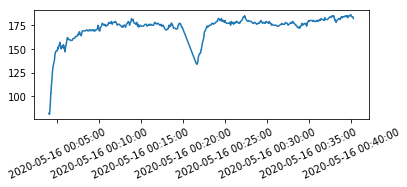

In [31]:
ax=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks( rotation=25 )
plt.plot(df['timestamp'],df['heart_rate'])
plt.gcf().subplots_adjust(bottom=0.5)
plt.savefig(filename.replace('.csv',''))
plt.show()


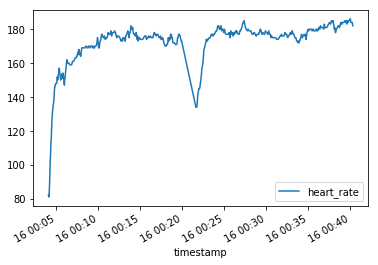

In [32]:
import matplotlib.dates as mdates
ax = df.plot(x='timestamp', y= 'heart_rate')
# set monthly locator
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
# # set formatter
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# # set font and rotation for date tick labels
# plt.gcf().autofmt_xdate()

plt.show()

In [48]:
files = os.listdir(os.getcwd()+'/data')
csv_files = [file for file in files if file[-4:].lower()=='.csv']

class friend:
    def __init__(self, name, resting_hr):
        self.name = name
        self.resting_hr = resting_hr
        
        
friends = [friend('kacy', 60), friend('chris', 60)]

'kacy'

In [52]:
len(df)

508

In [58]:
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)



In [56]:
past_r = None
total_points = 0
for r in df.iterrows():
    if past_r is not None:
        t_delta = (r[1]['timestamp'] - past_r[1]['timestamp']).total_seconds() /60
        points = r[1]['heart_rate'] * t_delta
        total_points += points
    past_r = r

print(total_points)

6207.983333333333


In [41]:
r[1]



timestamp       2020-05-16 00:04:03
heart_rate                       82
timestamp_16                      0
Name: 0, dtype: object